# Metabolomic signatures of NAFLD

Reference: Study ID ST001710

Background: Nonalcoholic fatty liver disease (NAFLD) is a progressive liver disease that is strongly associated with type 2 diabetes.  Accurate, non-invasive diagnostic tests to delineate the different stages: degree of steatosis, grade of nonalcoholic steatohepatitis (NASH) and stage fibrosis represent an unmet medical need. Here we report underlying associations between clinical data, lipidomic profiles, metabolic profiles and clinical outcomes, including downstream identification of potential biomarkers for various stages of the disease.

In [1]:
using LinearAlgebra,StatsModels
using MatrixLM
using CSV, DataFrames
using StatsBase
using Random
using Plots, FreqTables
Random.seed!(1)

TaskLocalRNG()

## Data description

The data was collected from [workbench](https://www.metabolomicsworkbench.org/data/DRCCMetadata.php?Mode=Study&DataMode=TreatmentData&StudyID=ST001710&StudyType=MS&ResultType=1#DataTabs). After initial data processing, there are three files would be involved in this Demonstration.

For the metabolomic data(`Y`), we have totally 68 different triglycerides for totally 473 subjects. 

For each triglyceride(`Z`), we have the number of carbon atom number and total double bound number.

For each subject(`X`), we have following 7 clinical variables. 

**Variables for each subject:**    

-`T2DM` => type 2 diabetes mellitus (DummyCoding) 

-`Kleiner_Steatosis` => Stage of Non-Alcoholic Fatty Liver Disease (NAFLD)  (EffectsCoding)

-`NAS` => NAS score (NAFLD Activity Score) represents the sum of scores for steatosis, lobular -inflammation, and ballooning, and ranges from 0-8.   

-`Platelets_E10_9_per_L` => platelets count (10⁹/L)   

-`Liver_ALT` => alanine aminotransferase test (ALT) level   

-`Liver_AST` => aspartate aminotransferase test (AST) level   

-`AST_ALT_Ratio` => AST/ALT ratio  useful in medical diagnosis   


In [2]:
# loading the data
clinicalDF = CSV.read("ST001710_ClinicalCovariates.csv",DataFrame)
metabolitesTG = CSV.read("MetaboTG.csv",DataFrame)
refTG = CSV.read("refTriglycerides.csv",DataFrame);

In [3]:
print(describe(clinicalDF))

9×7 DataFrame
 Row │ variable               mean      min            median    max            nmissing  eltype   
     │ Symbol                 Union…    Any            Union…    Any            Int64     DataType 
─────┼─────────────────────────────────────────────────────────────────────────────────────────────
   1 │ SampleID                         ID_1022383529            ID_1028971709         0  String15
   2 │ T2DM                             N                        Y                     0  String1
   3 │ Kleiner_Steatosis      1.9852    1              2.0       3                     0  Int64
   4 │ Inflammation           1.50317   1              1.0       3                     0  Int64
   5 │ NAS                    4.56237   2              5.0       8                     0  Int64
   6 │ Platelets_E10_9_per_L  770.537   75             228.0     255000                0  Int64
   7 │ Liver_ALT              68.5328   12             59.0      355                   0  Int64
   8 │ Li

In [4]:
print(describe(refTG)) # Total carbon number and total double bound

5×7 DataFrame
 Row │ variable         mean     min                 median  max                 nmissing  eltype   
     │ Symbol           Union…   Any                 Union…  Any                 Int64     DataType 
─────┼──────────────────────────────────────────────────────────────────────────────────────────────
   1 │ metabolite_name           TG(14:0/16:0/18:1)          TG(58:9)                   0  String31
   2 │ RefMetName                TG 14:0_16:0_18:1           TG(18:2/22:5/16:0)         0  String31
   3 │ metabolite_ID             ME399158                    ME399228                   0  String15
   4 │ Total_C          52.0597  45                  52.0    58                         0  Int64
   5 │ Total_DB         3.16418  0                   3.0     9                          0  Int64

In [5]:
freqtable(refTG.Total_DB)

10-element Named Vector{Int64}
Dim1  │ 
──────┼───
0     │  9
1     │  9
2     │ 11
3     │ 11
4     │  9
5     │  8
6     │  4
7     │  2
8     │  2
9     │  2

In [6]:
freqtable(refTG.Total_C)

12-element Named Vector{Int64}
Dim1  │ 
──────┼───
45    │  1
47    │  3
48    │  5
49    │  4
50    │ 10
51    │  5
52    │ 11
53    │  4
54    │ 11
55    │  1
56    │  9
58    │  3

From the frequency table above, the distribution of Z is inbalanced and we need to transform them.

In [7]:
# Transformation
refTG2 = copy(refTG)
refTG2.Total_DB[findall(refTG.Total_DB.>=6)] .=6;
refTG2.Total_C[findall(refTG.Total_C.<=50)] .=1;
refTG2.Total_C[findall(refTG.Total_C.>50 .&& refTG.Total_C.<=55)] .=2;
refTG2.Total_C[findall(refTG.Total_C.>55)] .=3;

In [8]:
freqtable(refTG2.Total_DB)

7-element Named Vector{Int64}
Dim1  │ 
──────┼───
0     │  9
1     │  9
2     │ 11
3     │ 11
4     │  9
5     │  8
6     │ 10

In [9]:
freqtable(refTG2.Total_C)

3-element Named Vector{Int64}
Dim1  │ 
──────┼───
1     │ 23
2     │ 32
3     │ 12

## Model Decision

Our first model would be simple, with only one variable(`T2DM`) are included into the design matrix.

### Model: T2DM

In [10]:
X_1 = design_matrix(@mlmFormula(1 + T2DM), clinicalDF, 
        [(:T2DM, DummyCoding())]) # using dummy coding for T2DM
Z = design_matrix(@mlmFormula(Total_C), refTG2, [(:Total_C , StatsModels.FullDummyCoding())])

Y = Matrix(metabolitesTG)[:, 2:end]; # Remove first column
#Z= 1* Matrix(I, size(Y, 2), size(Y, 2));

`@mlmFormula` are similar with the `@formula` from the package `StatsModels`. The `mlmFormula` macro takes expression like `1 + a*b` to construct design matrix.

Operators that have special interpretations in this syntax are:

- `+` concatenates variables as columns when generating a model matrix.
- `&` representes an interaction between two or more variables, which corresponds to a row-wise kronecker product of the individual terms (or element-wise product if all terms involved are continuous/scalar).
- `*` expands to all main effects and interactions: `a*b` is equivalent to `a+b+a&b`, `a*b*c` to `a+b+c+a&b+a&c+b&c+a&b&c`, etc.
- `1`, `0`, and `-1` indicate the presence (for `1`) or absence (for `0` and `-1`) of an intercept column.


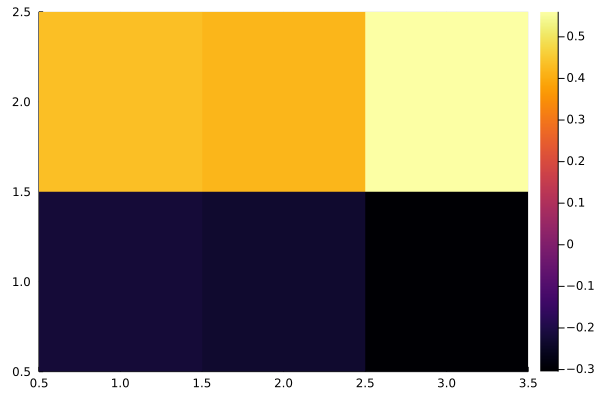

In [11]:
dat = RawData(Response(Y), Predictors(X_1, Z)) # Build raw data object
# Matrix linear model estimation, we already add an intercept when building design matrix
est = mlm(dat, hasXIntercept=false, hasZIntercept=false) 
esti_coef = MatrixLM.coef(est)
heatmap(esti_coef) # Visualize the marix for estimation coefficients by using heatmap.

After the model estimation, we will use permutation test to calculate t statistics and p value.

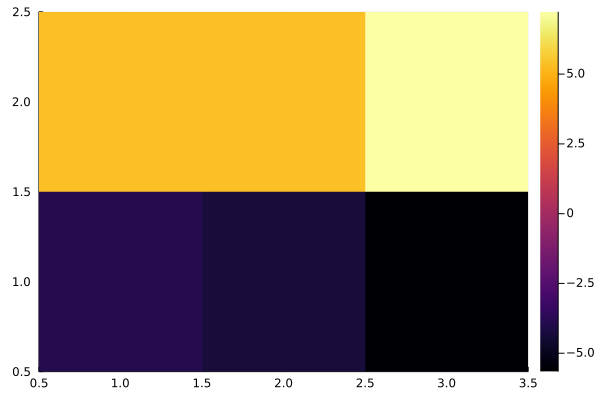

In [12]:
nPerms = 5
# confusing about specifying again intercept boolean
tStats, pVals = mlm_perms(dat, nPerms, hasXIntercept=false, hasZIntercept=false) 
heatmap(tStats)

In [13]:
tStats

2×3 Matrix{Float64}:
 -3.95943  -4.35042  -5.65807
  5.37923   5.37272   7.23153

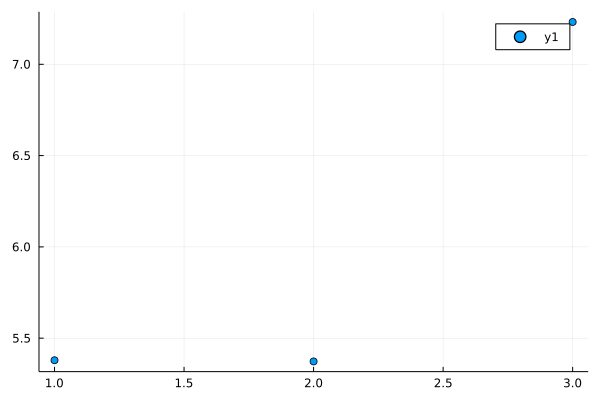

In [14]:
scatter(permutedims(tStats)[:,2])

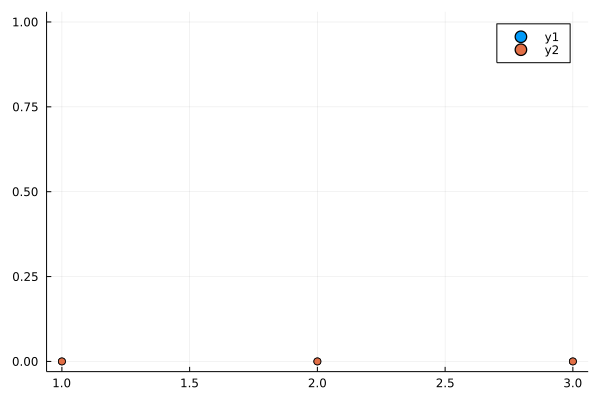

In [15]:
scatter(permutedims(pVals))

From the model above, the triglycerides of all carbon numbers are significantly different between the people without diabeties and with diabeties.

### Model: T2DM adjusted by 

Now, controlling for T2DM, we further examine the effect on other variables. `X_2` matrix add `Kleiner_Steatosis` to the design matrix.

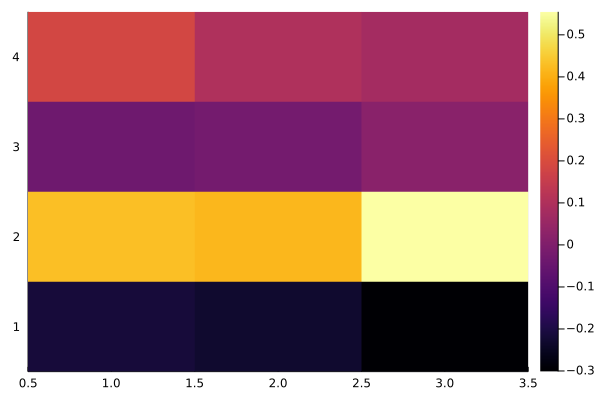

In [16]:
X_2 = design_matrix(@mlmFormula(1 + T2DM + Kleiner_Steatosis), clinicalDF, 
        [(:T2DM, DummyCoding()) , (:Kleiner_Steatosis , EffectsCoding())])
dat_2 = RawData(Response(Y), Predictors(X_2, Z)) # Build raw data object
est_2 = mlm(dat_2, hasXIntercept=false, hasZIntercept=false) # Matrix linear model estimation
esti_coef2 = MatrixLM.coef(est_2)
heatmap(esti_coef2) # Visualize the marix for estimation coefficients by using heatmap.

In [17]:
tStats2, pVals2 = mlm_perms(dat_2, nPerms, hasXIntercept=false, hasZIntercept=false);

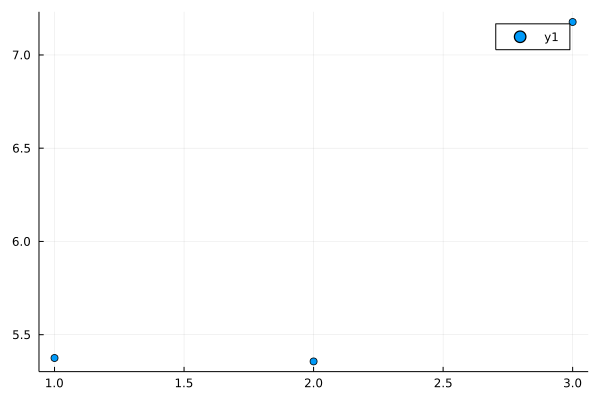

In [18]:
scatter(permutedims(tStats2)[:,2])

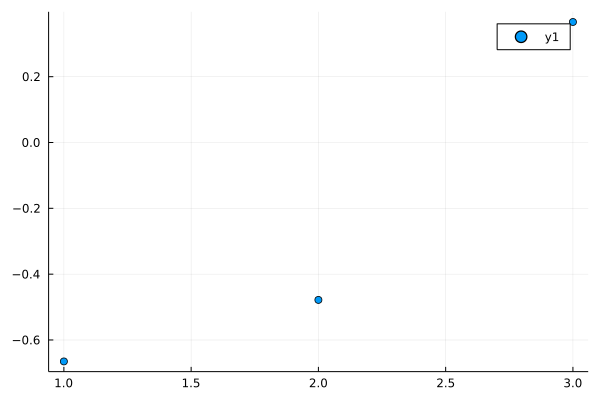

In [19]:
scatter(permutedims(tStats2)[:,3])

In [20]:
pVals2

4×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.6  1.0  1.0
 0.0  0.4  0.6

From the scatter plot, the stage of `Kleiner_Steatosis` is not significant among the subjects with and without diabetes.